# Hamming vs Jaccard

To compare a pair of binary pixel grids, we can slightly modify the notion of Hamming *distance*, which simply counts the number of differents bits in a pair of binary strings, and define the Hamming *similarity*, which is simply one minus the distance normalized by the string length (which should be the same for both strings). With Numpy and its XOR function, it's very easy to define:

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def hamming_similarity(g1, g2):
    return np.sum(~np.logical_xor(g1, g2)) / g1.size

hamming_similarity(np.asarray([1,0,1,0]), np.asarray([1,0,1,1]))

0.75

Now if we consider pixel grids of $4 \times 4$ with a 50% density (i.e. with 8 pixels turned on; please note that from now on, a "pixel" is always going to mean an "on" one), this notion of similarity seems to make sense:

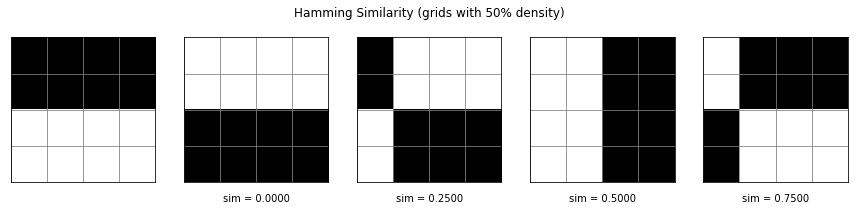

In [2]:
grids = [
    [1] * 8 + [0] * 8,
    [0] * 8 + [1] * 8,
    [1,0,0,0] * 2 + [0,1,1,1] * 2,
    [0,0,1,1] * 4,
    [0,1,1,1] * 2 + [1,0,0,0] * 2
]
         
def show_grids(grids, sim_fn, title, n=4):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 20))
    g0 = np.asarray(grids[0]).reshape(n, n)
    for i in range(5):
        gi = np.asarray(grids[i]).reshape(n, n)
        axes[i].imshow(gi, cmap='Greys', interpolation='nearest', extent=[0, n, 0, n])
        axes[i].grid(ls='solid', color='gray')
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_xticks(range(n))
        axes[i].set_yticks(range(n))
        for tic in axes[i].xaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
        for tic in axes[i].yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
        if i:
            axes[i].set_xlabel('sim = %.4f' % sim_fn(g0, gi))
        axes[2].set_title(title + '\n')
            
show_grids(grids, sim_fn=hamming_similarity, title='Hamming Similarity (grids with 50% density)')

However, when we consider grids with 4 pixels (thus with 25% density), something begins to look strange:

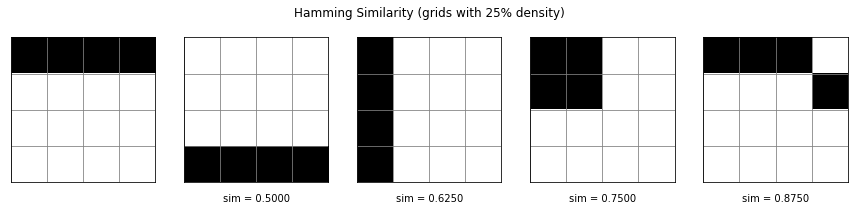

In [3]:
grids = [
    [1] * 4 + [0] * 12,
    [0] * 12 + [1] * 4,         
    [1,0,0,0] * 4,
    [1,1,0,0] * 2 + [0] * 8,
    [1,1,1,0] + [0,0,0,1] + [0] * 8
]
                  
show_grids(grids, sim_fn=hamming_similarity, title='Hamming Similarity (grids with 25% density)')

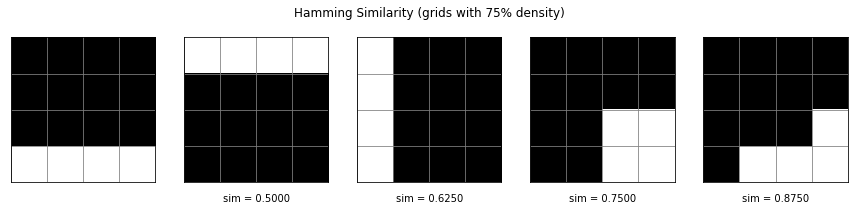

In [4]:
grids = [
    [1] * 12 + [0] * 4,
    [0] * 4 + [1] * 12,
    [0,1,1,1] * 4,
    [1] * 8 + [1,1,0,0] * 2,
    [1] * 8 + [1,1,1,0] + [1,0,0,0]
]
                  
show_grids(grids, sim_fn=hamming_similarity, title='Hamming Similarity (grids with 75% density)')

It seems that there is no way to create a grid with 4 pixels that is less than 50% similar to the first one (you are free to try). But intuitively, there would also seem to be at least a certain sense in which the second grid above could be considered completely dissimilar from the first (i.e. 0% similar), in virtue of the fact that none of the 4 pixels of the first grid can be found in the second. Let's look at what happens if we consider another function, the Jaccard similarity:

$$ J = \frac{|s_1 \cap s_2|}{|s_1 \cup s_2|}$$

which in our context can be interpreted as: the number of pixels shared by both grids divided by their total number of pixels. This again is very easy with Numpy:

In [5]:
def jaccard_similarity(g1, g2):
    s1 = set(np.argwhere(g1.flatten() == True).flatten())
    s2 = set(np.argwhere(g2.flatten() == True).flatten())
    return len(s1 & s2) / len(s1 | s2) 

This similarity function produces results that are somewhat more intuitive on the previous set of 4-pixel grids:

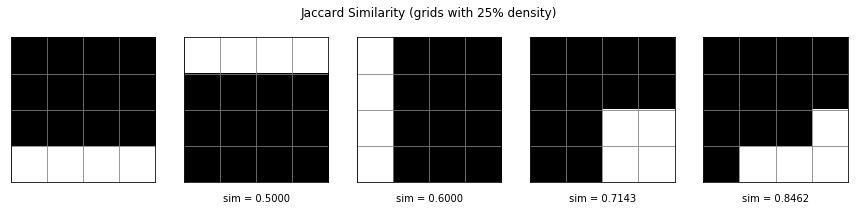

In [6]:
show_grids(grids, sim_fn=jaccard_similarity, title='Jaccard Similarity (grids with 25% density)')

For sets of pixels of equal size $p$ (4 in our examples so far), the Jaccard similarity function is:

$$J(k) = \frac{p-k}{p+k}$$

where $k$ can be interpreted as "$p$ - the number of shared pixels". For a slightly bigger $p$, it can be interesting to visualize this function:

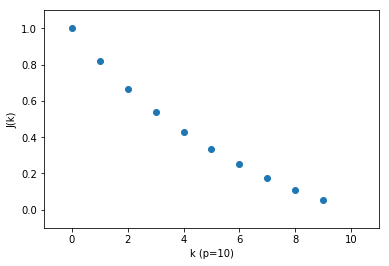

In [9]:
n = 10
a = np.arange(n, 0, -1)
b = np.arange(n, n * 2)
plt.scatter(range(n), a/b)
plt.xlim(-1, 11)
plt.ylim(-0.1, 1.1)
plt.xlabel('k (p=10)')
plt.ylabel('J(k)');

We can isolate $k$ in the equation above:

$$k = round\left(\frac{p - p \cdot J(k)}{1 + J(k)}\right)$$

which we can then use to define a procedure to generate a similar grid from a given grid and a desired Jaccard similarity value. This function simply calculates the number of pixels which would need to be different for that similarity value, then flips "off" a random sample of "on" pixels of exactly that size, and finally do the opposite, by flipping "on" a random set of "off" pixels of the same size.

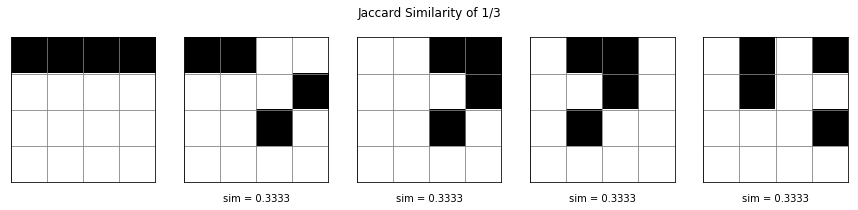

In [10]:
def get_similar_grid(g, jaccard_sim):
    h = g.flatten()
    pos = np.argwhere(h == True).flatten()
    neg = np.argwhere(h == False).flatten()
    n_pos = len(pos) # p
    n_to_flip = (n_pos - (n_pos * jaccard_sim)) / (1 + jaccard_sim) # k
    n_to_flip = int(round(n_to_flip))
    pos_flip = np.random.choice(pos, n_to_flip, replace=False)
    neg_flip = np.random.choice(neg, n_to_flip, replace=False)
    h[pos_flip] = False
    h[neg_flip] = True
    return h.reshape(g.shape)

g0 = np.asarray([1] * 4 + [0] * 12).reshape(4, 4)
grids = [g0] + [get_similar_grid(g0, 1/3) for _ in range(4)]
show_grids(grids, jaccard_similarity, 'Jaccard Similarity of 1/3')

Finally, here is a more randomized version of the generating function, where the number of pixels to flip can vary, as they are picked by sampling a uniform distribution with probability $\frac{k}{p}$, where $k$ can be interpreted here as the number of pixels to flip (given the desired similarity level) and $p$ as the number of pixels:

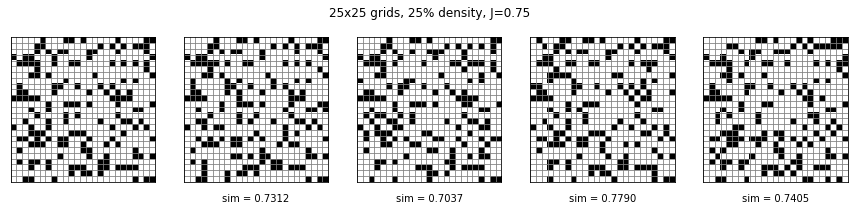

In [11]:
def get_similar_grid2(g, jaccard_sim):
    h = g.flatten()
    pos = np.argwhere(h == True).flatten()
    n_pos = len(pos) # p
    n_to_flip = (n_pos - (n_pos * jaccard_sim)) / (1 + jaccard_sim) # k
    n_to_flip = int(round(n_to_flip))
    flip_prob = n_to_flip / n_pos # k / p
    pos_flip = np.random.random(n_pos) <= flip_prob
    neg = np.argwhere(h == False).flatten()
    h[pos] = np.logical_xor(h[pos], pos_flip)
    h[np.random.choice(neg, sum(pos_flip), replace=False)] = True
    return h.reshape(g.shape)

n = 25
g0 = np.floor(np.random.random((n, n)) + 0.25)
grids = [g0] + [get_similar_grid2(g0, 0.75) for _ in range(4)]

show_grids(grids, jaccard_similarity, title='25x25 grids, 25% density, J=0.75', n=n)

And finally, we note that the procedure above (as well as the Jaccard similarity function as defined) would break for grids with density higher than 50%). But fortunately there is an easy fix: simply invert the meaning of a "pixel" (i.e. treat "on" pixels as "off", and vice versa), in the cases where the density is above the 50% threshold.

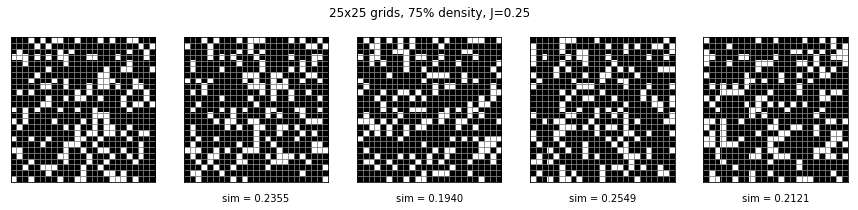

In [12]:
def jaccard_similarity2(g1, g2):
    b = True if np.sum(g1) / g1.size <= 0.5 else False
    s1 = set(np.argwhere(g1.flatten() == b).flatten())
    s2 = set(np.argwhere(g2.flatten() == b).flatten())
    return len(s1 & s2) / len(s1 | s2) 

def get_similar_grid3(g, jaccard_sim):
    h = g.flatten()
    b = True if np.sum(g) / g.size <= 0.5 else False
    pos = np.argwhere(h == b).flatten()
    n_pos = len(pos) # p
    n_to_flip = (n_pos - (n_pos * jaccard_sim)) / (1 + jaccard_sim) # k
    n_to_flip = int(round(n_to_flip))
    flip_prob = n_to_flip / n_pos # k / p
    pos_flip = np.random.random(n_pos) <= flip_prob
    neg = np.argwhere(h == (not b)).flatten()
    h[pos] = np.logical_xor(h[pos], pos_flip)
    h[np.random.choice(neg, sum(pos_flip), replace=False)] = b
    return h.reshape(g.shape)

n = 25
g0 = np.floor(np.random.random((n, n)) + 0.75)
grids = [g0] + [get_similar_grid3(g0, 0.25) for _ in range(4)]

show_grids(grids, jaccard_similarity2, title='25x25 grids, 75% density, J=0.25', n=n)